# COGS 118A - Final Project

# Exploring a Multimodal Approach to Predicting Need for Mechanical Ventilation in the ICU

## Group members

- Armaan Johal

# Abstract 

Predicting a patient's need for mechanical ventilation in the ICU can positively impact patient outcomes and asssit clinicians in decision making. Existing DeepLearning predictive models exist, but they are limited to training on one modality. This project aims to explore combining prediction scores to see if it can improve performance. I am using pre-calculated prediction scores from two DeepLearning models, VentNet and a COVID-19 Pneumonia Chest-Xray model, with a total of 1,440 patients from UC San Diego Hospital, each with hourly scores up to 72 hours. After combining both DeepLearning scores with a Random Forest classifier and evaluating performance on the ground truth labels, the multimodal model performed significantly better than both DeepLearning models at predicting need for mechanical ventilation. The AUROC increased by 3%, from 85% for the VentNet model to 88%, and both specificity and PPV increased by over 20%, to 98% and 87% respectfully. These results show that combining modalities has potential improve prediction performance for patients in the ICU.

# Background

Mechanical ventilation is the medical term for using a machine to assist in the breathing of the patient, oftentimes in response to patient deterioration in the form of cardiac arrest or respiratory failure<a name="1"></a>[<sup>[1]</sup>](#1). About 300,000 patients receive mechanical ventilation in the US each year<a name="2"></a>[<sup>[2]</sup>](#2), with the most common causes being low oxygen levels or shortness of breath from an infection such as pneumonia. Due to the invasive nature of ventilation, a patient placed on invasive mechanical ventilation has an increased risk of mortality as well as an increased risk of additional complications such as septic shock, heart failure, and pulmonary embolism<a name="3"></a>[<sup>[3]</sup>](#3). In addition to the increased risk of morbidity and mortality in patients, excessive mechanical ventilation in the ICU can burden hospital resources and nursing staff, so knowing which patients might need ventilation and when would assist in the logistics of mechanical ventilation distribution and availability<a name="2"></a>[<sup>[2]</sup>](#2).

Early prediction of a patient’s need for mechanical ventilation would give clinicians additional lead time to plan and execute an intervention. This realtime prediction would also reduce the risk of morbidity and mortality of patients, as interventions could be taken sooner. There already exist multiple clinically accepted prediction scores, such as the Simplified Acute Physiology Score II (SAPS II), Oxford Acute Severity of Illness Score (OASIS), and Sequential Organ Failure Assessment (SOFA), which are widely used with ICU populations<a name="4"></a>[<sup>[4]</sup>](#4). However, these scores are calculated using simple vital ratios and clinical observations which might not be fully generalizable. In practice, identifying a patient’s need for mechanical ventilation before obvious symptoms emerge can be challenging due to the varied nature of patient deterioration and variability among patient populations. These simpler prediction scores work well for quick evaluation of a patient’s condition, but they lack performance on broader patient populations<a name="5"></a>[<sup>[5]</sup>](#5).

Driven by research efforts in response to COVID-19, there have been attempts to create predictive models for patient need for mechanical ventilation<a name="6"></a>[<sup>[6]</sup>](#6)<a name="7"></a>[<sup>[7]</sup>](#7)<a name="8"></a>[<sup>[8]</sup>](#8). Many of these models, like the Deep Learning model VentNet, performed very well with a 24-hour prediction horizon on ICU patients, with an AUC of  > 0.9 for prospective validation among patients with COVID-19<a name="7"></a>[<sup>[7]</sup>](#7). However, these models for early prediction only take advantage of structured data stored in the electronic health record (EHR) system. A patient might have other relevant data (clinical notes, X-rays, medical scans, documents) that are not included in the EHR data and that might be important for the predictive model to consider.


# Problem Statement

Studies have shown that incorporating multiple data modalities into a multimodal model can improve prediction performance. Specifically, it has been shown that leveraging the chest x-ray modality alongside physiological data could improve multimodal phenotyping for medical applications<a name="9"></a>[<sup>[9]</sup>](#9). 

This project aims to answer the question: does combining the EHR data with chest x-ray data in a multimodal prediction model improve prediction performance of a patient's need for mechanical ventilation? 

Answering this specific question could be a step towards asking the broader question: can combining independent Deep Learning models improve prediction accuracy?

# Data

The data I obtained for this project comes from the Department of Biomedical Informatics at UC San Diego, where I am part of a research team focused on translational clinical research. 

The dataset contains data from 1,440 patients from UC San Diego's ICU unit. Each patient has three .csv files in this dataset.

The first .csv contains a single score for each hour that the patient is in the hospital (h x 1). This score is the prediction score for the patient's need for mechanical ventilation - which is the output of the VentNet DeepLearning model [LINK]. This score is computed using the patient's Electronic Health Record data. A score of 1 means that the model thinks the patient absolutely needs mechanical ventilation. A score of 0 means that the model thinks that the patient absolutely does not need mechanical ventilation.

The second .csv contains three scores for each hour that the patient is in the hospoital (h x 3). These scores come from the AI model developed by Dr. Albert Hsaio to diagnose COVID-19 pneumonia in Chest-Xrays. The first score is the pneumonia diagnosis confidence score, the second score is a clinical measurement of the patient (ignored for this project), and the third score is the masking. A masking score of 0 indicates that the pneumonia diagnosis confidence score is a new value, whereas a masking score of 1 indicated that the pneumonia diagnosis confidence score is unchanged from the previous hour. 

The third .csv contains the ground truth label for each hour that the patient is in the hospical (h x 1). A label of 0 indicates that the patient is not on mechanical ventilation and a label of 1 indicates that the patient is on mechanical ventilation. The dataset is evenly split - half the patients in this dataset have a ground truth label of 1, the other half have a label of 0.


Before performing my analysis, I had to clean the data. I loaded all the .csv files into three numpy arrays - one for the VentNet scores, one for the Chest-Xray scores, and one for the ground truth labels. Because each patient's stay in the hospital varies, the number of scores per patient is different. To standardize, I flattened all the data into a large zero-padded array:

In [7]:
import numpy as np
import pandas as pd

# Directory where vent net scores are stored
ventNet_scoreDir = './data_v2/cxrayCohort_ventNetScore_v2/'
cxray_scoreDir = './data_v2/cxrayCohort_cxray_scores_v2/'
# Directory where outcome labels are stores
outcomeDir = './data_v2/cxrayCohort_outcome_v2/'

# File list containing list of all files
fileList_str = './data_v2_filenames.txt'

fileList_f = open(fileList_str, 'r')
fileList = fileList_f.readlines()
fileList_f.close()

# Maximum record length for each ED encounter
maxSeqLength = 340 # in hours
N = len(fileList)

X = np.zeros((N, maxSeqLength), dtype = np.float32)
Y = np.zeros((N, maxSeqLength), dtype = np.float32)
X_cxray = np.zeros((N, maxSeqLength), dtype = np.float32)
X_cxray_nonrepeat = np.zeros((N, maxSeqLength), dtype = np.float32)
seqLength = np.zeros(N, dtype = np.int32)


# Load the csv files into a numpy array
ventNet_index_list = []
cxray_index_list = []
for i in range(N):
    ventNet_data_csv = (pd.read_csv(ventNet_scoreDir + fileList[i][0:-1], header = None)).values
    seqLength[i] = ventNet_data_csv.shape[0]
    X[i, 0:seqLength[i]] = np.squeeze(ventNet_data_csv)
    
    #Add indices of non-padded values to ventNet_index_list
    for j in range (ventNet_data_csv.shape[0]):
        ventNet_index_list.append(j + maxSeqLength*i)
    
    cxray_data_csv = (pd.read_csv(cxray_scoreDir + fileList[i][0:-1], header = None)).values
    #seqLength[i] = cxray_data_csv.shape[0]
    X_cxray[i, 0:seqLength[i]] = np.squeeze(cxray_data_csv[:,0])
    
    #Add indices of non-padded values to cxray_index_list
    for k in range (cxray_data_csv.shape[0]):
        cxray_index_list.append(k + maxSeqLength*i)
        
    #Only keeping Chest X ray values that are new (mask value = 0)
    cxray_data_csv[cxray_data_csv[:,2] == 1] = 0
    X_cxray_nonrepeat[i, 0:seqLength[i]] = np.squeeze(cxray_data_csv[:,0])

    outcome_data_csv = (pd.read_csv(outcomeDir + fileList[i][0:-1], header = None)).values
    Y[i, 0:seqLength[i]] = np.squeeze(outcome_data_csv)

There were also quite a few missing values (NaNs) in the dataset, so I decided to impute all  NaN values with the mean score across all patients with mask 0 (non-repeated values):

In [8]:
#Convert all NaNs to mean of non-repeated ChestXray Value across all patients
X_cxray_nonrepeat[X_cxray_nonrepeat == 0] = np.nan
mean = np.nanmean(X_cxray_nonrepeat)
X_cxray = np.nan_to_num(X_cxray, nan=mean)

# Proposed Solution

In this project, I will combine the scores of two models together, using the existing VentNet model, which is trained on EHR data, with the existing AI diagnosis model for COVID-19 pneumonia[8], which is trained on Chest-X Rays, to create a multimodal prediction model for patient need for mechanical ventilation. 

After the data cleaning, I will have three numpy arrays of size (1,440 x 1). I will combine the numpy arrays for the VentNet scores and Chest-Xray scores together into my X, which will have size (1,440 x 2). The ground truch numpy array (1,440 x 1) will be the y. I will then run nested cross-validation on X for algorithm comparison, where I will find the "best" ML algorithm (Logistic Regression, Random Forest, SVC, KNN).

The selected model will be tested on the ground truth labels to calculate performance. The performance of this combined model will be compared to the performance of each model individually (using the evaluation metrics defined below) to determine whether combining the scores led to better prediction. Based on the results, I will be able to determine whether a multimodal approach is advantageous or detrimental for predicting patient need for mechanical ventilation. 



# Evaluation Metrics

For evaluation I plan to use:
- Area Under the ROC Curve (AUROC)
- Area Under ther Precision-Recall Curve (AUC-PR)
- False Positives (FP)
- Specificity or True Negative Rate (SPC)
- Positive Predictive Value (PPV)

I will primarily be evaluating performance using the AUROC because is can best show the tradeoff in performance over varying TPR/FPR. I will compute AUROC as the area under a piecewise linear function of TPR and FPR. I will also compute AUC-PR as the area under a piecewise linear function of recall and precision. 

I am including the other evaluation metrics because they are still relevant to understanding model performance. For example, in the ICU, patients put on mechanical ventilation unecessarily can cause complications like infection and severe deterioration. Therefore, we want the False Positives to be lower. These evaluation metrics are derived using the basic error metrics from the confusion matrices. 

Derivations of the evaluation metrics and how they are computed mathematically are in the supplemental file "Supplemental-Code-FinalProject"

Note: "snooze" refers to how long the model should be ignored after flagging a positive for a patient. I wanted to include this because having a model snooze functionality is best-practice in clinical applications. It does not impact the evaluation metrics.


In [9]:
# One of the functions that computes the TP, FP, FN, and TN using a confusion matric
def compute_confusion_matrix_per_patient(labels, predictions, threshold, seqLength, snooze_length = 0):   
    # Fill-in confusion matrix.
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    snooze = 0
    
    for t in range(seqLength):       
        # Only check labels and predictions when not snoozed.
        if snooze == 0:           
            label = labels[t] == 1
            prediction = predictions[t] >= threshold 
            if label and prediction:
                tp += 1
            elif not label and prediction:
                fp += 1
            elif label and not prediction:
                fn += 1
            elif not label and not prediction:
                tn += 1

            if prediction:
                snooze = snooze_length
                
        else:
            snooze -= 1
            
    return tp, fp, fn, tn

# Results

### Importing the necessary libraries

In [150]:
import numpy as np
import pandas as pd

import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### Evaluating Baseline Performance 

Error Metrics VentNet: AUC- 0.853627287853401 AUCpr- 0.6613911108739366 FP- 930.0 SPC  0.7660377358490567 PPV  0.5211122554067971
Error Metrics Chest X-ray: AUC- 0.7745696157869202 AUCpr- 0.5197817629257029 FP- 1063.0 SPC  0.6704897706137631 PPV  0.48795761078998073


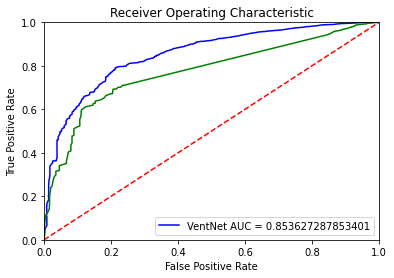

In [128]:
warnings.filterwarnings("ignore")

#AUC for individual scores
truePositiveHorizon = 48 # 48+24 = 72 hours
snoozeDuration = 6 # hours

# Compute AUC
auc, _, aucpr_modified, tpr, fp, ppv_modified, spc, T = compute_ppvModified_snoozed_auc(Y, X, seqLength, truePositiveHorizon, snoozeDuration, 500) 
indx = np.where(tpr>=0.80)[0][0]
fp = fp[indx]
print ("Error Metrics VentNet: AUC-", auc, "AUCpr-", aucpr_modified, "FP-", fp, "SPC ", spc[indx], "PPV ", ppv_modified[indx])

plt.title('Receiver Operating Characteristic')
plt.plot((1-tpr), spc, 'b', label = "VentNet AUC = "+str(auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc, _, aucpr_modified, tpr, fp, ppv_modified, spc, T = compute_ppvModified_snoozed_auc(Y, X_cxray, seqLength, truePositiveHorizon, snoozeDuration, 500) 
indx = np.where(tpr>=0.80)[0][0]
fp = fp[indx]
print ("Error Metrics Chest X-ray: AUC-", auc, "AUCpr-", aucpr_modified, "FP-", fp, "SPC ", spc[indx], "PPV ", ppv_modified[indx])


plt.plot((1-tpr), spc, 'g', label = "AUC = "+str(auc))
plt.show()

As we can see, the AUROC for the VentNet model prediction is 85%, while the AUROC for the Chest X-ray model is 77%. The model struggles in specificity and has a high number of false positives, more than half of the dataset! Additionally, the Positive predictive value is about 0.5, which is the same as chance for a binary classification task. 

Let's see if combining the scores can improve the performance. In order to combine the scores, we first need to prep the data for our algorithm selection:

### Preparing Data for Algorithm Selection

We will feed the two scores from the models into multiple ML algorithms and determine the "best" one. Before that, we must flatten our numpy arrays:

<AxesSubplot:xlabel='VentNet Score', ylabel='Chest Xray Score'>

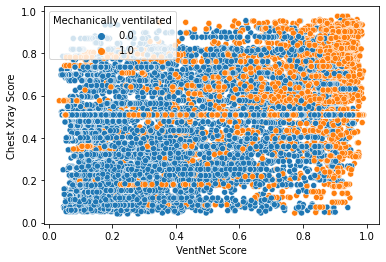

In [69]:
# Logistic Model to combine scores
X_ventNet_flat_all = X.flatten()
X_cxray_flat_all = X_cxray.flatten()
y_true_all = Y.flatten()

X_ventNet_flat = X_ventNet_flat_all[ventNet_index_list]
X_cxray_flat = X_cxray_flat_all[cxray_index_list]
y_true = y_true_all[cxray_index_list]

X_labels = np.vstack((X_ventNet_flat, X_cxray_flat)).T

All_data = np.vstack((X_ventNet_flat, X_cxray_flat, y_true)).T
df = pd.DataFrame(All_data, columns=['VentNet Score','Chest Xray Score','Mechanically ventilated'])
sns.scatterplot(data=df, x='VentNet Score', y='Chest Xray Score', hue='Mechanically ventilated')

### Algorithm Selection

The next step is choosing the "best" algorithm. I was initially going to use nested cross validation for algorithm selection, but after trying it for multiple algorithms, there seemed to be no improvement at all for different hyperparameters. In other words, hyperparameter tuning seemed to have little to no effect on the accuracy of the model. This is probably because the data is only two-dimensional, so the hyperparameters cannot have much impact. Below is an example of nested cross validation that I attempted for Logistic Regression.

In [111]:
# Example of nested cross validation

# Pipeline created using Logistic Regression
pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=10000))
# Create the parameter grid
param_grid = [{
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]
}]
# Create the Grid Search estimator instance for selecting model
gs = GridSearchCV(estimator=pipeline, param_grid = param_grid,
                 cv = 2, scoring = 'accuracy', n_jobs = 1, refit = True)
# Calculate the generalization error / accuracy
scores = cross_val_score(gs, X_labels, y_true, scoring='accuracy', cv=5)

# Print the mean scores and standard deviation
print('Logistic Regression Score w/ nested cross validation: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

model = LogisticRegression()
model.fit(X_labels, y_true) # Training model on entire training dataset
score = model.score(X_test, y_test)
print("Logistic Regression Score w/o nested cross validation: " + str(score))

Logistic Regression Score w/ nested cross validation: 0.765 +/- 0.006
Logistic Regression Score w/o nested cross validation: 0.7671130952380952


As you can see, the scores for nested cross validation were actually slightly worse than normal train-test split. Because of the computational intensity and fruitlessness of nested cross validation, I decided to simply do normal cross validation to find the "best" model. I performed 5-fold cross validation on four algorithms: Logistic Regression, Support Vector Machines, KNN, and Random Forest.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_labels, y_true, test_size=0.2, random_state=0)

In [108]:
model = LogisticRegression()
cv_results = cross_validate(model, X_train, y_train, cv=5, return_estimator=True)
print("Logistic Regression test_score mean: " + str(cv_results['test_score'].mean()))

model = SVC(probability=True)
cv_results = cross_validate(model, X_train, y_train, cv=5, return_estimator=True)
print("SVC test_score mean: " + str(cv_results['test_score'].mean()))


model = KNeighborsClassifier()
cv_results = cross_validate(model, X_train, y_train, cv=5, return_estimator=True)
print("KNN test_score mean: " + str(cv_results['test_score'].mean()))


model = RandomForestClassifier()
cv_results = cross_validate(model, X_train, y_train, cv=5, return_estimator=True)
print("RF test_score mean: " + str(cv_results['test_score'].mean()))


Logistic Regression test_score mean: 0.766089412171732
SVC test_score mean: 0.7699019817715935
KNN test_score mean: 0.7553011795487226
RF test_score mean: 0.779667347799293


Based of the results from the 5-fold cross validation, Random Forest seems to be the best algorithm. The performance after combining the scores from the two DeepLearning models is the highest, and this type of decision tree model makes sense for the scattered data. 

I will now train the Random Forest model on all of the training data and evaluate the performance.

### Model Evaluation

RF Score: 0.78125
RF Error Metrics: AUC- 0.8826093558016278 AUCpr- 0.8054074827737733 FP- 140.0 SPC  0.982976653696498 PPV  0.8724954462659381


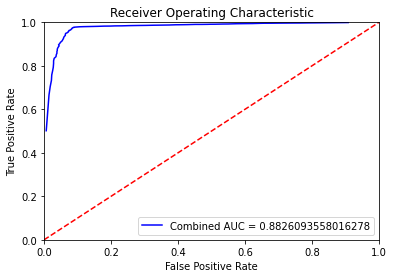

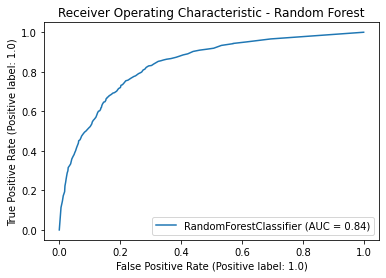

In [156]:
# Random Forest

model = RandomForestClassifier()
model.fit(X_train, y_train) # Training model on entire training dataset
score = model.score(X_test, y_test)
print("RF Score: " + str(score))
predictions = model.predict_proba(X_labels)[:,1]
predictions.shape

#Reconstructing into zero-padded (933,340) array
X_combined_rf = np.zeros((N, maxSeqLength), dtype = np.float32)
inc = 0
for i in range(N):
    X_combined_rf[i, 0:seqLength[i]] = predictions[inc:inc+seqLength[i]]
    inc += seqLength[i]
    
#AUC for combined scores
truePositiveHorizon = 48 # 48+24 = 72 hours
snoozeDuration = 6 # hours

auc, _, aucpr_modified, tpr, fp, ppv_modified, spc, T = compute_ppvModified_snoozed_auc(Y, X_combined_rf, seqLength, truePositiveHorizon, snoozeDuration, 500) 
indx = np.where(tpr>=0.80)[0][0]
fp = fp[indx]
print ("RF Error Metrics: AUC-", auc, "AUCpr-", aucpr_modified, "FP-", fp, "SPC ", spc[indx], "PPV ", ppv_modified[indx])

plt.title('Receiver Operating Characteristic')
plt.plot((1-tpr), spc, 'b', label = "Combined AUC = "+str(auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plot_roc_curve(model, X_test, y_test) 
plt.title('Receiver Operating Characteristic - Random Forest')
plt.show()


### VentNet model prediction error metrics:
**AUC: 0.853**  
**AUCpr: 0.661**  
**FP: 930**  
**SPC:  0.766**  
**PPV:  0.521**  

### Combined VentNet + CXray Multimodal model error metrics:
**AUC: 0.882**  
**AUCpr: 0.805**  
**FP: 140**  
**SPC:  0.982**  
**PPV:  0.872**  

Wow!

As seen from the RF Error Metrics, the calculated AUROC for the Random Forest combined score model is 88.2%, which is almost 3% higher than the individual VentNet AUROC! This improvement can be seen in the AUROC graph as well.

# Discussion

### Interpreting the result

From these results, we can clearly see that combining the two DeepLearning scores together using a Random Forest classifier and evaluating its performance with the ground truth labels led to an overall improvement. More specifically, there are a few key observations from these results:

The AUROC is about 3% higher for the combined model than for the individual VentNet Model, meaning the combined model is better distinguishing between the positive and negative classes.

The AUC-pr value is about 14% higher for the combined model than for the individual VentNet Model. This means that the model has both high recall and high precision (low false positive rate, low false negative rate), which can have significant implications on clinical applications in the ICU since false classification could be potentially fatal.

Another fascinating improvement is the False Positives, which are down from 930 in the individual VentNet model to just 140. That is still about 10% of classifications as false positives, but this shows a drastic improvement over the individual models.

Interestingly, the strongest result to me seems to be the improvement in specificity from 76% to over 98%, showing the model is able to accurately designate a patient who does not need mechanical ventilation as negative. This would not be a surprising result in an imbalanced dataset, since always predicting negative could lead to a very high specificity for conditions that are rare. However, this dataset is 50-50 in terms of positive and negative class, so this high specificity is quite surprising and perhaps shows that incorporating more data could give higher confidence to negative prediction. PPV also improved significantly from 52% to 87%, meaning the confidence of positive prediction increased as well. Perhaps the extra information gained with the Chest-Xray score decreased informational entropy allowed the model to better understand the patient. In terms of the RF algorithm, perhaps the Chest-Xray score shifted the cutoff of a few important decision stumps, which could have imparted higher confidence when classifying patients as positive or negative. 


### Limitations

Perhaps the biggest limitation to this work is the size of the data. I only had 1,440 data points, which is very small for any generalizable ML project. On top of a limited number of data points, the dimensionality of the data only consisted of two scores, which defintely limited the effectiveness of hyperparameter tuning and model selection. 

This data also used already computed scores from two different models - the VentNet Model and the Chest Xray Pneumonia model. The results from this project are dependent on the accuracy of those models and the data that were used to train those models, which is out-of-scope for this project. Perhaps pertubations in the training data for the two models could have let to inconsistent scores.

Another limitation is that this dataset is split 50-50 between patients with mechanical ventilation and patients without mechanical ventilation. In the real world, only about 0.2% of patients in the ICU are placed on mechanical ventilation, so the results of this study may not be reflective of its applications in real-world clinical settings. 

Future work should focus on increasing the size of the dataset, and perhaps generating scores with visibility into the training data as to avoid data inconsistencies. Gathering data from other hospitals would also be beneficial for generalization. 


### Ethics & Privacy

The data used in this project didn't contain any patient health information, so any direct data privacy issues are not applicable. However, any project that uses health data directly or indirectly needs to consider how the data is being collected and whether the storage of sensitive data is secure.

In addition to data privacy, there are some serious ethical implications with these DeepLearning models, especially when deploying them for use in clinical settings. During the peak of the COVID-19 pandemic, mechanical ventilators were extremely limited and the number of people in need ot ventilation far exceeded availability. In these cases of extreme resource pressure, how does a model decide who should recieve ventilation and who shouldn't? What happens when the model has a false negative or false positive? Who is liable for a patient's complications as a result of a model-assisted clinical decision?

When training the model, there are also areas for bias in the model that can negatively impact some patients. For example, patients who do not have insurance or cannot afford care at UC San Diego Hospital are not represented in this model, since it is trained on UC San Diego ICU data. As a result, if the model had to predict need for mechanical ventilation one of these underrepresented patients, the prediction might be biased and miss certain factors that were not included during training.  

To address these issues, more work has to be done on diversifying the dataset and clearly outlining the scope of the model (what it can and cannot do) if it is deployed in clinical applications.


### Conclusion

Overall, this project has shown that combining scores from two independent DeepLearning models can significantly improve performance for predicting patient need for mechanical ventilation in the ICU. This project indicates that a multimodal approach to prediction can be advantageous and has implications for future work in DeepLearning prediction in the ICU.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem

<a name="1"></a>1.[^](#1): Mechanical Ventilation - Statpearls - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK539742/. 

<a name="2"></a>2.[^](#2): Ventilator-Associated Event (VAE) - Centers for Disease Control and ... https://www.cdc.gov/nhsn/pdfs/pscmanual/10-vae_final.pdf. 

<a name="3"></a>3.[^](#3): Roedl, Kevin, et al. “Mechanical Ventilation and Mortality among 223 Critically Ill Patients with Coronavirus Disease 2019: A Multicentric Study in Germany.” Australian Critical Care : Official Journal of the Confederation of Australian Critical Care Nurses, U.S. National Library of Medicine, Mar. 2021, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7590821/. 

<a name="4"></a>4.[^](#4): Zhu, Yibing, et al. “Machine Learning Prediction Models for Mechanically Ventilated Patients: Analyses of the Mimic-III Database.” Frontiers, Frontiers, 1 June 2021, https://www.frontiersin.org/articles/10.3389/fmed.2021.662340/full. 

<a name="5"></a>5.[^](#5): Ferrari D, Milic J, Tonelli R, Ghinelli F, Meschiari M, Volpi S, et al. (2020) Machine learning in predicting respiratory failure in patients with COVID-19 pneumonia—Challenges, strengths, and opportunities in a global health emergency. PLoS ONE 15(11): e0239172. https://doi.org/10.1371/journal.pone.0239172

<a name="6"></a>6.[^](#6): Bolourani S, Brenner M, Wang P, McGinn T, Hirsch JS, Barnaby D, Zanos TP, Northwell COVID-19 Research Consortium A Machine Learning Prediction Model of Respiratory Failure Within 48 Hours of Patient Admission for COVID-19: Model Development and Validation J Med Internet Res 2021;23(2):e24246 URL: http://www.jmir.org/2021/2/e24246/ doi: 10.2196/24246 PMID: 33476281

<a name="7"></a>7.[^](#7): Shashikumar SP, Wardi G, Paul P, Carlile M, Brenner LN, Hibbert KA, North CM, Mukerji SS, Robbins GK, Shao YP, Westover MB, Nemati S, Malhotra A. Development and Prospective Validation of a Deep Learning Algorithm for Predicting Need for Mechanical Ventilation. Chest. 2021 Jun;159(6):2264-2273. doi: 10.1016/j.chest.2020.12.009. Epub 2020 Dec 17. PMID: 33345948; PMCID: PMC8027289.

<a name="8"></a>8.[^](#8): Carlile M, Hurt B, Hsiao A, Hogarth M, Longhurst CA, Dameff C. Deployment of artificial intelligence for radiographic diagnosis of COVID-19 pneumonia in the emergency department. J Am Coll Emerg Physicians Open. 2020 Nov 5;1(6):1459-1464. doi: 10.1002/emp2.12297. PMID: 33392549; PMCID: PMC7771783.

<a name="9"></a>9.[^](#9): Towards Dynamic Multi-Modal Phenotyping Using Chest Radiographs and ... https://www.researchgate.net/publication/355925038_Towards_dynamic_multi-modal_phenotyping_using_chest_radiographs_and_physiological_data. 
